# Initial Setup

In [1568]:
#importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from google.colab import drive
from sklearn.model_selection import train_test_split,KFold,GridSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import r2_score
from scipy import stats
from scipy.stats import norm, skew 
import warnings
warnings.filterwarnings("ignore")

In [1569]:
#importing the file

df=pd.read_csv('https://cdn.upgrad.com/UpGrad/temp/9cefd607-bbb7-443d-bb3e-eac9fef04453/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [1570]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [1571]:
# understanding the data

df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [1572]:
# getting the list of columns wich has  more than 1 null values

sorted({k:i for k,i in df.isna().sum().items() if i>0}.items(), key=lambda x: x[1], reverse=True)

[('PoolQC', 1453),
 ('MiscFeature', 1406),
 ('Alley', 1369),
 ('Fence', 1179),
 ('FireplaceQu', 690),
 ('LotFrontage', 259),
 ('GarageType', 81),
 ('GarageYrBlt', 81),
 ('GarageFinish', 81),
 ('GarageQual', 81),
 ('GarageCond', 81),
 ('BsmtExposure', 38),
 ('BsmtFinType2', 38),
 ('BsmtQual', 37),
 ('BsmtCond', 37),
 ('BsmtFinType1', 37),
 ('MasVnrType', 8),
 ('MasVnrArea', 8),
 ('Electrical', 1)]

It seems there are many columns which may need missing value treatment and also scaling is needed

# Data understanding and cleaning

Understanding the target column


 mu = 180921.20 and sigma = 79415.29



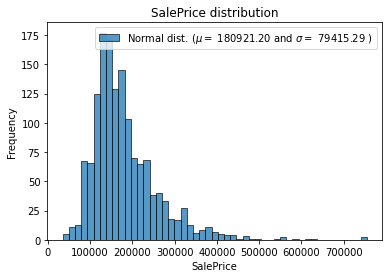

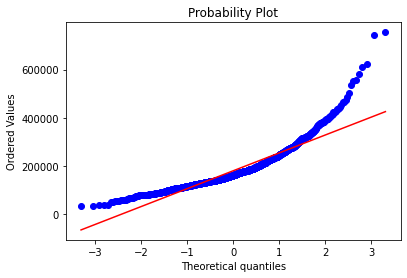

In [1573]:
sns.histplot(df['SalePrice'] , hue_norm=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)
plt.show()

The target variable is right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.


 mu = 12.02 and sigma = 0.40



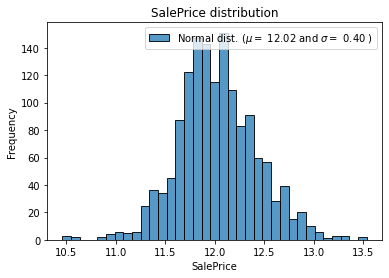

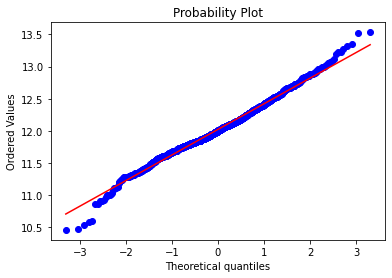

In [1574]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df["SalePrice"] = np.log1p(df["SalePrice"])
sns.histplot(df['SalePrice'] , hue_norm=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)
plt.show()


# #removing the outliers will also give a normal distribution
# df=df[(df.SalePrice>=11) & (df.SalePrice <=13.25)]
# sns.boxplot(data=df,x='SalePrice')
# plt.show()
# df.SalePrice.describe()

In [1575]:

# now hecking columns with more than 80% if junk values 
# we have arbitarily decided threshold of 80% but it makes sense as imputing 80% missing values if too much effort and may not be so accurate to real world data

for c in df.columns:
  percent=(df[c].isna().sum()/len(df[c]))*100
  if percent>=75:
    print(c," total junk values ",percent,"%  i.e. ",df[c].isna().sum())
    #df=df.drop(columns=[c])



Alley  total junk values  93.76712328767123 %  i.e.  1369
PoolQC  total junk values  99.52054794520548 %  i.e.  1453
Fence  total junk values  80.75342465753424 %  i.e.  1179
MiscFeature  total junk values  96.30136986301369 %  i.e.  1406


In [1576]:
#set id as unique id if it is unique
rows,cols = df.shape

if (len(df.Id.unique())==rows):
  df.set_index('Id', inplace=True)

In [1577]:

#droping duplicate records
df=df.drop_duplicates()

In [1578]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247699
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109016
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317171
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849405
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429220


In [1579]:
len(df.index)

1460

In [1580]:

# getting the list of columns wich has  more than 1 null values

sorted({k:i for k,i in df.isna().sum().items() if i>0 }.items(), key=lambda x: x[1], reverse=True)

[('PoolQC', 1453),
 ('MiscFeature', 1406),
 ('Alley', 1369),
 ('Fence', 1179),
 ('FireplaceQu', 690),
 ('LotFrontage', 259),
 ('GarageType', 81),
 ('GarageYrBlt', 81),
 ('GarageFinish', 81),
 ('GarageQual', 81),
 ('GarageCond', 81),
 ('BsmtExposure', 38),
 ('BsmtFinType2', 38),
 ('BsmtQual', 37),
 ('BsmtCond', 37),
 ('BsmtFinType1', 37),
 ('MasVnrType', 8),
 ('MasVnrArea', 8),
 ('Electrical', 1)]

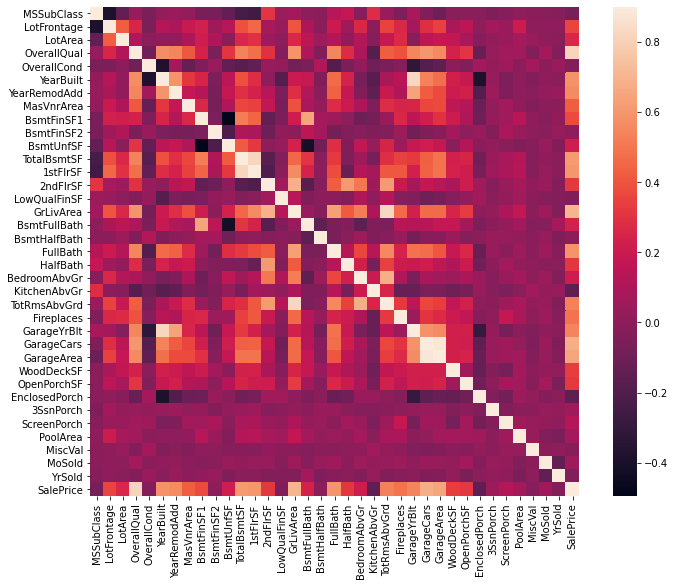

In [1581]:
#Correlation map to see how features are correlated with SalePrice
corrmat = df.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [1582]:
#correlation with SalePrice top 20 variables
a=df.corr()['SalePrice']
a.sort_values(ascending=False)[1:21]

OverallQual     0.817185
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
YearRemodAdd    0.565608
GarageYrBlt     0.541073
TotRmsAbvGrd    0.534422
Fireplaces      0.489450
MasVnrArea      0.430809
BsmtFinSF1      0.372023
LotFrontage     0.355879
WoodDeckSF      0.334135
OpenPorchSF     0.321053
2ndFlrSF        0.319300
HalfBath        0.313982
LotArea         0.257320
Name: SalePrice, dtype: float64

In [1583]:
# a quick view on the top positively and negatively co-related 

print (a.sort_values(ascending=False)[:5], '\n')
print (a.sort_values(ascending=False)[-5:])

SalePrice      1.000000
OverallQual    0.817185
GrLivArea      0.700927
GarageCars     0.680625
GarageArea     0.650888
Name: SalePrice, dtype: float64 

YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
Name: SalePrice, dtype: float64


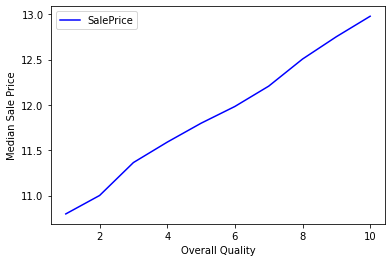

In [1584]:
quality_pivot = df.pivot_table(index='OverallQual',
                  values='SalePrice', aggfunc=np.median)
quality_pivot.plot(kind='line', color='blue')
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

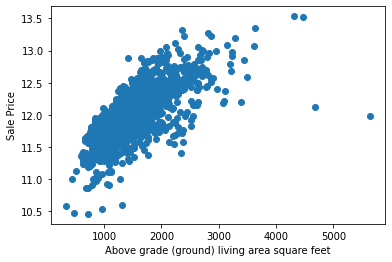

In [1585]:
plt.scatter(x=df['GrLivArea'], y=df.SalePrice)
plt.ylabel('Sale Price')
plt.xlabel('Above grade (ground) living area square feet')
plt.show()

Before removing any null values we will refer to https://cdn.upgrad.com/UpGrad/temp/87f67e28-c47e-4725-ae3c-111142c7eaba/data_description.txt to determine which NAs are actually nulls

We impute them by proceeding sequentially through features with missing values

PoolQC : data description says NA means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general. Likewise there are many other columns as per the metadata where NA does not mean the data is actually missing instead it implies other thing.

In [1586]:
# Imputing missing values as nones
na_not_nulls=['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','KitchenQual','GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature','FireplaceQu']

# OrdinalEncoder will be used
ordinal_categorical=['LandSlope','OverallQual','OverallCond','BsmtQual','BsmtCond','BsmtFinType1','BsmtExposure','BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish',
                     'GarageQual','GarageCond','PoolQC','Fence','LotShape','LandContour','ExterQual','ExterCond','PavedDrive','MiscVal','Utilities']

# Label encode will be used with n-1 classes
nominal_categorical=['MSSubClass','MSZoning','LotConfig','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType',
                     'Foundation','Heating','Electrical','GarageType','MiscFeature','SaleType','SaleCondition','Alley']

# OneHotEncoder will be used for binary variables
binary_categorical=['Street','CentralAir']

# Numeric variables may be scaled further
numeric_cols=['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
              'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea']
              #Data dictionary has 'Bedroom','Kitchen' but train data does not contain that

In [1587]:
# lets impute missing values where NA does not mean data is missing.

for col in na_not_nulls:
  df[col]=df[col].fillna('None')

sorted({k:i for k,i in df.isna().sum().items() if i>0 }.items(), key=lambda x: x[1], reverse=True)

[('LotFrontage', 259),
 ('GarageYrBlt', 81),
 ('MasVnrType', 8),
 ('MasVnrArea', 8),
 ('Electrical', 1)]

In [1588]:
df.LotFrontage.describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

There is a huge difference between 75th percentile and max. It is becuase there are outliers

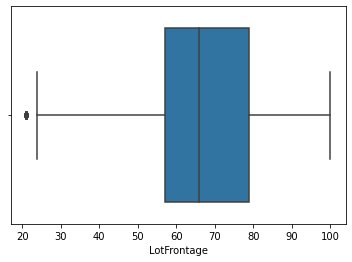

In [1589]:
df=df[(df.LotFrontage<=df.LotFrontage.quantile(q=0.93))]
sns.boxplot(data=df,x='LotFrontage')
plt.show()

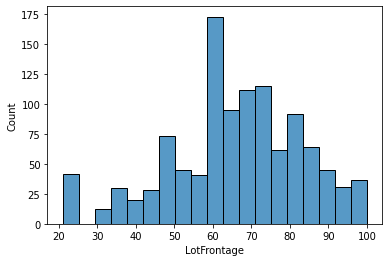


 remaining variables with missing values
[('GarageYrBlt', 71), ('MasVnrType', 5), ('MasVnrArea', 5), ('Electrical', 1)]


In [1590]:
sns.histplot(data=df,x=df.LotFrontage)
plt.show()

# as it is normally distributed mean can safely be used to impute missing values
df.LotFrontage=df.LotFrontage.fillna(df.LotFrontage.mean())
df.LotFrontage.mean()

print('\n remaining variables with missing values')
print(sorted({k:i for k,i in df.isna().sum().items() if i>0 }.items(), key=lambda x: x[1], reverse=True))

In the remaining columns the number of missing values is not significant hence it can be droped off

In [1591]:
print(df.shape)
df=df.dropna()
print(sorted({k:i for k,i in df.isna().sum().items() if i>0 }.items(), key=lambda x: x[1], reverse=True))
print(df.shape)

(1117, 80)
[]
(1040, 80)


In [1592]:
# checking whether some rows have more than 6 missing values
# here threshold  is chosen arbitarily but it make sense as this type of records would result in error
print(len(df[df.isnull().sum(axis=1) > 5].index))
df=df[df.isnull().sum(axis=1) <= 5]

0


Here the missing values are handled

In [1593]:
df[numeric_cols].head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea
Id,,,,,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,8,0,2,548,0,61,0,0,0,0
2,80.0,9600,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,6,1,2,460,298,0,0,0,0,0
3,68.0,11250,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,6,1,2,608,0,42,0,0,0,0
4,60.0,9550,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,7,1,3,642,0,35,272,0,0,0
5,84.0,14260,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,9,1,3,836,192,84,0,0,0,0


# Feature engineering

In [1594]:
# let have a look through the numeric columns

df[numeric_cols].head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea
Id,,,,,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,8,0,2,548,0,61,0,0,0,0
2,80.0,9600,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,6,1,2,460,298,0,0,0,0,0
3,68.0,11250,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,6,1,2,608,0,42,0,0,0,0
4,60.0,9550,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,7,1,3,642,0,35,272,0,0,0
5,84.0,14260,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,9,1,3,836,192,84,0,0,0,0


After looking at the numeric columns somthings are very clear <br>


> BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF = TotalBsmtSF <br>
> 1stFlrSF + 2ndFlrSF + LowQualFinSF = GrLivArea



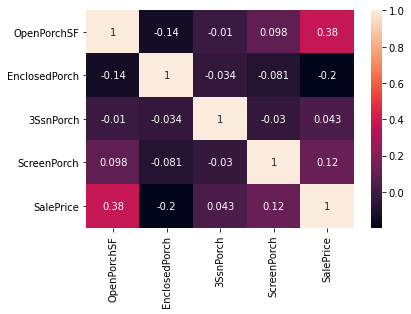

In [1595]:
# understand the proch area with the salesprice
sns.heatmap(data= df[['OpenPorchSF','EnclosedPorch',	'3SsnPorch',	'ScreenPorch' ,'SalePrice']].corr(),annot=True)

Variables '3SsnPorch' and	'ScreenPorch' have low co relation with the target variable.

In [1596]:



#performing all trandformation on both x and y seperately

df['TtlPorchArea'] = df.OpenPorchSF + df.EnclosedPorch + df['3SsnPorch'] + df.ScreenPorch 

df['TtlBath'] = df.FullBath + 0.5*df.HalfBath + df.BsmtFullBath + 0.5*df.BsmtHalfBath




df['Age'] = df['YrSold'] - df['YearBuilt']
df['Remod_Age'] = abs(df['YrSold'] - df['YearRemodAdd'])



# columns that has low co relation or are multicolinear can be removed safely. We will keep amending the list further

drop_cols=['OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','1stFlrSF','2ndFlrSF','LowQualFinSF','FullBath','HalfBath','BsmtFullBath',
           'BsmtHalfBath','YrSold','YearBuilt','YearRemodAdd']

# newly added features
numeric_cols=numeric_cols+['TtlPorchArea','TtlBath','Age','Remod_Age']





df[list(set(numeric_cols)-set(drop_cols))].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1040 entries, 1 to 1460
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TotRmsAbvGrd  1040 non-null   int64  
 1   GarageArea    1040 non-null   int64  
 2   Age           1040 non-null   int64  
 3   MasVnrArea    1040 non-null   float64
 4   TtlBath       1040 non-null   float64
 5   LotArea       1040 non-null   int64  
 6   TtlPorchArea  1040 non-null   int64  
 7   LotFrontage   1040 non-null   float64
 8   TotalBsmtSF   1040 non-null   int64  
 9   PoolArea      1040 non-null   int64  
 10  WoodDeckSF    1040 non-null   int64  
 11  GrLivArea     1040 non-null   int64  
 12  Remod_Age     1040 non-null   int64  
 13  GarageCars    1040 non-null   int64  
 14  Fireplaces    1040 non-null   int64  
dtypes: float64(3), int64(12)
memory usage: 130.0 KB


In [1597]:
list(set(numeric_cols)-set(drop_cols))

['TotRmsAbvGrd',
 'GarageArea',
 'Age',
 'MasVnrArea',
 'TtlBath',
 'LotArea',
 'TtlPorchArea',
 'LotFrontage',
 'TotalBsmtSF',
 'PoolArea',
 'WoodDeckSF',
 'GrLivArea',
 'Remod_Age',
 'GarageCars',
 'Fireplaces']

Now lets work on categorical variables 

In [1598]:
print(binary_categorical)

df['Street']=df['Street'].apply(lambda x : 1 if x=='Grvl' else 0)
df['CentralAir']=df['CentralAir'].apply(lambda x : 1 if x=='Y' else 0)



df[binary_categorical].info()

['Street', 'CentralAir']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1040 entries, 1 to 1460
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Street      1040 non-null   int64
 1   CentralAir  1040 non-null   int64
dtypes: int64(2)
memory usage: 24.4 KB


In [1599]:
# now we will look into ordinal categorical variables
print(ordinal_categorical)
print(len(ordinal_categorical))

# these variables are already in numeric variables
removelist=['OverallQual','OverallCond','MiscVal']

# replace NA with None
temp_dic1={'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
temp_dic2={'None':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6}
temp_dic3={'None':0,'No':1,'Mn':2,'Av':3,'Gd':4}
temp_dic4={'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4}
temp_dic5={'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7}
temp_dic6={'None':0,'Unf':1,'RFn':2,'Fin':3}
temp_dic7={'None':0,'Fa':1,'TA':2,'Gd':3,'Ex':4}
temp_dic8={'IR3':0,'IR2':1,'IR1':2,'Reg':3}
temp_dic9={'Low':0,'HLS':1,'Bnk':2,'Lvl':3}
temp_dic10={'None':0,'MnWw':1,'GdWo':2,'MnPrv':3,'GdPrv':4}
temp_dic11={'ELO':0,'NoSeWa':1,'NoSewr':2,'AllPub':3}




df['LandSlope'] =  df.LandSlope.map({'Gtl':0,'Mod':1,'Sev':2})
df['BsmtQual'] = df.BsmtQual.map(temp_dic1)
df['BsmtCond'] = df.BsmtCond.map(temp_dic1)
df['BsmtFinType1'] = df.BsmtFinType1.map(temp_dic2)
df['BsmtExposure'] = df.BsmtExposure.map(temp_dic3)
df['BsmtFinType2'] = df.BsmtFinType2.map(temp_dic2)
df['HeatingQC'] = df.HeatingQC.map(temp_dic4)
df['KitchenQual'] = df.KitchenQual.map(temp_dic4)
df['Functional'] = df.Functional.map(temp_dic5)
df['FireplaceQu'] = df.FireplaceQu.map(temp_dic1)
df['GarageFinish'] = df.GarageFinish.map(temp_dic6)
df['GarageQual'] = df.GarageQual.map(temp_dic1)
df['GarageCond'] = df.GarageCond.map(temp_dic1)
df['PoolQC'] = df.PoolQC.map(temp_dic7)
df['LotShape'] = df.LotShape.map(temp_dic8)
df['LandContour'] = df.LandContour.map(temp_dic9)
df['ExterQual'] = df.ExterQual.map(temp_dic4)
df['ExterCond'] = df.ExterCond.map(temp_dic4)
df['PavedDrive'] = df.PavedDrive.map({'N':0,'P':1,'Y':2})
df['Fence'] = df.Fence.map(temp_dic10)
df['Utilities'] = df.Utilities.map(temp_dic11)





print(df[ordinal_categorical].info())

['LandSlope', 'OverallQual', 'OverallCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtExposure', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'LotShape', 'LandContour', 'ExterQual', 'ExterCond', 'PavedDrive', 'MiscVal', 'Utilities']
24
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1040 entries, 1 to 1460
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   LandSlope     1040 non-null   int64
 1   OverallQual   1040 non-null   int64
 2   OverallCond   1040 non-null   int64
 3   BsmtQual      1040 non-null   int64
 4   BsmtCond      1040 non-null   int64
 5   BsmtFinType1  1040 non-null   int64
 6   BsmtExposure  1040 non-null   int64
 7   BsmtFinType2  1040 non-null   int64
 8   HeatingQC     1040 non-null   int64
 9   KitchenQual   1040 non-null   int64
 10  Functional    1040 non-null   int64
 11  FireplaceQu   1040 non-nu

Now we will work on Nominal categorical variables

In [1600]:

# Before working on Nominal categories we will remove the columns that are safe to drop to reduce the complexity


print('before')
print(df.shape)

df=df.drop(columns=drop_cols)

print('after')
print(df.shape)



before
(1040, 84)
after
(1040, 67)


We initial had 81 column then after creating features and removing unecessary columns we have reached 66 columns 

In [1601]:
# lets create dummy variables with n-1 levels

print(nominal_categorical)
print(len(nominal_categorical))


# for training data
dummies=pd.get_dummies(df, prefix=nominal_categorical, columns=nominal_categorical,drop_first=True)
df=pd.concat([df,dummies],axis=1)

# removing nominal columns
df=df.drop(columns=nominal_categorical)


# removing any duplicate columns after merge
df = df.loc[:,~df.columns.duplicated()]

print('final grid')
print(df.shape)


['MSSubClass', 'MSZoning', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition', 'Alley']
21
final grid
(1040, 191)


Before performing any feture engineering or scaling the data will be splitted into train and test

In [1602]:
y = df.loc[:, 'SalePrice']
X = df.loc[:, df.columns != 'SalePrice']


# test train split 

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, 
                                                    random_state = 1)

print(X_train.shape)
print(X_test.shape)

(780, 190)
(260, 190)


In [1603]:
print(y_test.shape)
print(y_test.shape)

(260,)
(260,)


In [1604]:
# the numeric variables are ready to be uniformely scaled.



scaler = MinMaxScaler() #initializing object
mylist=list(set(numeric_cols)-set(drop_cols))
print('before')
print(X_train[mylist].describe())

X_train[mylist]=scaler.fit_transform(X_train[mylist]) # learning from train data and transforming
X_test[mylist]=scaler.transform(X_test[mylist]) # transforming test data

print('after')
print(X_train[mylist].describe())

before
       TotRmsAbvGrd   GarageArea  ...  GarageCars  Fireplaces
count    780.000000   780.000000  ...  780.000000  780.000000
mean       6.473077   493.434615  ...    1.857692    0.558974
std        1.548710   183.292725  ...    0.654013    0.631122
min        3.000000   160.000000  ...    1.000000    0.000000
25%        5.000000   352.000000  ...    1.000000    0.000000
50%        6.000000   484.000000  ...    2.000000    0.000000
75%        7.000000   578.000000  ...    2.000000    1.000000
max       12.000000  1134.000000  ...    4.000000    3.000000

[8 rows x 15 columns]
after
       TotRmsAbvGrd  GarageArea         Age  ...   Remod_Age  GarageCars  Fireplaces
count    780.000000  780.000000  780.000000  ...  780.000000  780.000000  780.000000
mean       0.385897    0.342335    0.284914  ...    0.368141    0.285897    0.186325
std        0.172079    0.188186    0.245615  ...    0.351809    0.218004    0.210374
min        0.000000    0.000000    0.000000  ...    0.000000    0.

Scalling seems to be reflected perfectly

# Setting up Model

In [1605]:
X_train.head()

,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,TotalBsmtSF,HeatingQC,CentralAir,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,PoolArea,PoolQC,Fence,MiscVal,...,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Alley_None,Alley_Pave
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1115,0.873418,0.059026,0,3,3,3,0,5,7,0.00000,2,3,3,3,1,3,1,0.259825,4,1,0.124606,2,1,3,0.111111,7,0.000000,0,1955.0,1,0.000000,0.170431,3,3,2,0.000000,0.0,0,3,0,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
159,1.000000,0.161990,0,3,3,3,0,7,5,0.00000,3,2,4,3,1,6,1,0.309108,4,1,0.476025,3,1,3,0.555556,7,0.333333,4,2004.0,2,0.333333,0.531828,3,3,2,0.000000,0.0,0,2,0,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
1094,0.632911,0.114165,0,3,3,3,0,5,8,0.10375,2,2,3,3,2,6,1,0.269495,3,1,0.240379,1,1,3,0.333333,7,0.000000,0,1977.0,1,0.333333,0.743326,3,3,2,0.000000,0.0,0,3,0,...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
1027,0.658228,0.115173,0,3,3,3,0,5,5,0.20250,2,2,3,3,1,3,1,0.395508,2,1,0.260568,3,1,2,0.333333,7,0.666667,4,1960.0,1,0.333333,0.309035,3,3,2,0.000000,0.0,0,0,0,...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
335,0.481013,0.111458,0,2,3,3,0,6,5,0.00000,2,2,4,3,4,6,1,0.294136,3,1,0.378549,3,1,2,0.444444,7,0.666667,3,1998.0,3,0.333333,0.320329,3,3,2,0.116686,0.0,0,0,0,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0


In [1606]:
# To reduce number of features we will use rfe. we will select top 35 features

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

variable_limit=30


lm=LinearRegression()
lm.fit(X_train,y_train)
rfe=RFE(lm,variable_limit)
rfe=rfe.fit(X_train,y_train)

#list(zip(X_train.columns,rfe.support_,rfe.ranking_))

In [1607]:
print('before')
print(X_train.shape)
col=list(X_train.columns[rfe.support_])

X_train = X_train[ col]
X_test = X_test[ col]

print('after')
print(X_train.shape)
col

before
(780, 190)
after
(780, 30)


['LotArea',
 'Street',
 'TotalBsmtSF',
 'CentralAir',
 'GrLivArea',
 'GarageArea',
 'TtlPorchArea',
 'TtlBath',
 'Age',
 'MSSubClass_85',
 'MSSubClass_90',
 'MSSubClass_180',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Neighborhood_Crawfor',
 'Neighborhood_NridgHt',
 'Neighborhood_StoneBr',
 'Neighborhood_Veenker',
 'BldgType_Duplex',
 'BldgType_Twnhs',
 'HouseStyle_SFoyer',
 'RoofMatl_Membran',
 'RoofMatl_Roll',
 'RoofMatl_WdShngl',
 'Exterior1st_BrkComm',
 'Foundation_Slab',
 'Foundation_Stone',
 'SaleCondition_AdjLand']

In [1608]:
# creating a simple model with all the variables

import statsmodels.api as sm

X_train_sm=sm.add_constant(X_train)
#create first model
lr=sm.OLS(y_train,X_train_sm)

#fit the model
lr_model=lr.fit()


In [1609]:
print('Training score :')
round(r2_score(y_train,lr_model.predict(X_train_sm))*100,2)

Training score :


88.11

In [1610]:
print('Test score :')
round(r2_score(y_test,lr_model.predict(sm.add_constant(X_test)))*100,2)

Test score :


85.47

In [1611]:
print(lr_model.params)

const                    10.824430
LotArea                   0.263434
Street                   -0.227861
TotalBsmtSF               0.580510
CentralAir                0.159708
GrLivArea                 0.975098
GarageArea                0.261488
TtlPorchArea              0.235272
TtlBath                   0.215356
Age                      -0.390040
MSSubClass_85            -0.238904
MSSubClass_90            -0.175485
MSSubClass_180           -0.418299
MSZoning_FV               0.513283
MSZoning_RH               0.411121
MSZoning_RL               0.422433
MSZoning_RM               0.409309
Neighborhood_Crawfor      0.265029
Neighborhood_NridgHt      0.175053
Neighborhood_StoneBr      0.194734
Neighborhood_Veenker      0.166158
BldgType_Duplex          -0.175485
BldgType_Twnhs           -0.156281
HouseStyle_SFoyer         0.253240
RoofMatl_Membran          0.336211
RoofMatl_Roll             0.162577
RoofMatl_WdShngl          0.146099
Exterior1st_BrkComm      -0.502999
Foundation_Slab     

Although the model is good with 88% on train and 85% scores on train and test respectively there are few drawbacks <br>
 
1. The model is too complex and there is a sign of overfitting.

2. Because of this complexity there may be a scope for improvement for the model which is still unkown.

3. There is a difference in test and train score of about 2 % which can be reduce.

> We will use advance regression techniquies to genralize the model.

# Andvance regression

## Lasso

We will use this top 35 variable to perform advacne regression and make our model simpler

In [1612]:
# grid search CV

# set up cross validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# specify range of hyperparameters
params = {'alpha': [0.001, 0.01, 1.0, 5.0, 10.0]}

# grid search
# lasso model
model = Lasso()
model_cv = GridSearchCV(estimator = model, param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True, verbose = 1)            
model_cv.fit(X_train, y_train) 

cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.004527,0.000198,0.001851,0.000130,0.001,{'alpha': 0.001},0.831281,0.821733,0.806921,0.871998,0.887004,0.843787,0.030547,1,0.866464,0.867684,0.869650,0.855966,0.850406,0.862034,0.007505
1,0.004743,0.001505,0.001799,0.000106,0.01,{'alpha': 0.01},0.718912,0.722086,0.702634,0.736224,0.766780,0.729327,0.021558,2,0.749098,0.754530,0.758215,0.740249,0.724425,0.745303,0.012064
2,0.003515,0.000398,0.001737,0.000092,1,{'alpha': 1.0},-0.002324,-0.014072,-0.005366,-0.020664,-0.000153,-0.008516,0.007702,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.004296,0.001924,0.001748,0.000170,5,{'alpha': 5.0},-0.002324,-0.014072,-0.005366,-0.020664,-0.000153,-0.008516,0.007702,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.004944,0.001988,0.001926,0.000113,10,{'alpha': 10.0},-0.002324,-0.014072,-0.005366,-0.020664,-0.000153,-0.008516,0.007702,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


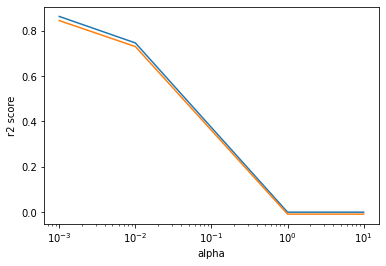

In [1613]:
# plot
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2 score')
plt.xscale('log')
plt.show()

There is no sign of overfitting. The optimal value is the initial value
> a point to note here is as we increase the value of alpha/lambda the model becomes more general and the bias is very high but on the other hand the variance is getting low.

In [1614]:
X_train.shape


(780, 30)

In [1615]:
# lasso regression
lm = Lasso(alpha=0.001)
lm.fit(X_train, y_train)

# predict
print('Train score')
y_train_pred = lm.predict(X_train)
print(round(r2_score(y_true=y_train, y_pred=y_train_pred)*100,2))
y_test_pred = lm.predict(X_test)
print('Test score')
print(round(r2_score(y_true=y_test, y_pred=y_test_pred)*100,2))

Train score
85.89
Test score
87.27


> As compared to the linear model we built earlier the train score has decreased and the test score increased. <br>
> This nature indicates how lasso adds a little bias in the model so that it can perform better on test data.

In [1616]:
# few more things to notice about lasso

# lasso model parameters
model_parameters = list(lm.coef_)
model_parameters.insert(0, lm.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X_train.columns
cols = cols.insert(0, "constant")

coefs=sorted(list(zip(cols, model_parameters)),key=lambda x:abs(x[1]),reverse=True)

top5inlasso=coefs[:6]

coefs


[('constant', 11.217),
 ('GrLivArea', 0.983),
 ('TotalBsmtSF', 0.535),
 ('Age', -0.369),
 ('GarageArea', 0.259),
 ('TtlBath', 0.238),
 ('Neighborhood_Crawfor', 0.233),
 ('MSSubClass_90', -0.225),
 ('LotArea', 0.175),
 ('CentralAir', 0.175),
 ('TtlPorchArea', 0.171),
 ('Neighborhood_NridgHt', 0.155),
 ('Neighborhood_StoneBr', 0.145),
 ('BldgType_Twnhs', -0.13),
 ('MSZoning_FV', 0.101),
 ('Neighborhood_Veenker', 0.066),
 ('Exterior1st_BrkComm', -0.049),
 ('MSZoning_RL', 0.037),
 ('RoofMatl_WdShngl', 0.017),
 ('MSZoning_RM', 0.008),
 ('Street', -0.001),
 ('MSSubClass_85', 0.0),
 ('MSSubClass_180', -0.0),
 ('MSZoning_RH', 0.0),
 ('BldgType_Duplex', -0.0),
 ('HouseStyle_SFoyer', 0.0),
 ('RoofMatl_Membran', 0.0),
 ('RoofMatl_Roll', 0.0),
 ('Foundation_Slab', 0.0),
 ('Foundation_Stone', 0.0),
 ('SaleCondition_AdjLand', 0.0)]

> Lasso indirectly perform feature selection as you can see many of the variables/Co-efficients like PavedDrive,GarageCond,GarageQual,GarageArea and many more has value as 0 which means the model will work at its best with or without these variable as the significance of these variables are close to 0

## Ridge

In [1617]:
# grid search CV

# set up cross validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# specify range of hyperparameters
params = {'alpha': [0.001, 0.01, 1.0, 5.0, 10.0]}

# grid search
# lasso model
model = Ridge()
model_cv = GridSearchCV(estimator = model, param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True, verbose = 1)            
model_cv.fit(X_train, y_train) 

cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.004813,0.002889,0.001759,0.000124,0.001,{'alpha': 0.001},0.852348,0.818449,0.833180,0.869480,0.894173,0.853526,0.026655,3,0.884593,0.887663,0.888980,0.878962,0.874608,0.882961,0.005418
1,0.003353,0.000123,0.001727,0.000184,0.01,{'alpha': 0.01},0.852521,0.818952,0.833087,0.869776,0.894355,0.853738,0.026627,2,0.884590,0.887661,0.888979,0.878960,0.874606,0.882959,0.005418
2,0.003357,0.000100,0.001657,0.000050,1,{'alpha': 1.0},0.848572,0.831970,0.825579,0.876723,0.898545,0.856278,0.027558,1,0.879405,0.881656,0.884422,0.872472,0.868022,0.877195,0.006057
3,0.003329,0.000096,0.002710,0.002148,5,{'alpha': 5.0},0.827319,0.822189,0.807525,0.850639,0.883283,0.838191,0.026469,4,0.858123,0.859069,0.862648,0.847558,0.842145,0.853908,0.007739
4,0.003934,0.000530,0.001788,0.000071,10,{'alpha': 10.0},0.804756,0.801345,0.785918,0.818201,0.860578,0.814159,0.025382,5,0.833281,0.833378,0.837687,0.822031,0.814788,0.828233,0.008492


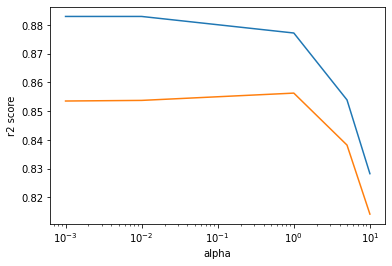

In [1618]:
# plot
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2 score')
plt.xscale('log')
plt.show()

In [1619]:
# Ridge regression
lm = Ridge(alpha=1)
lm.fit(X_train, y_train)

# predict
print('Train score')
y_train_pred = lm.predict(X_train)
print(round(r2_score(y_true=y_train, y_pred=y_train_pred)*100,2))
y_test_pred = lm.predict(X_test)
print('Test score')
print(round(r2_score(y_true=y_test, y_pred=y_test_pred)*100,2))

Train score
87.69
Test score
86.97


In [1620]:
# few more things to notice about lasso

# Ridge model parameters
model_parameters = list(lm.coef_)
model_parameters.insert(0, lm.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X_train.columns
cols = cols.insert(0, "constant")
coefs=sorted(list(zip(cols, model_parameters)),key=lambda x:abs(x[1]),reverse=True)

top5inridge=coefs[:6]

coefs

[('constant', 11.011),
 ('GrLivArea', 0.901),
 ('TotalBsmtSF', 0.528),
 ('Age', -0.377),
 ('MSZoning_FV', 0.329),
 ('Exterior1st_BrkComm', -0.315),
 ('GarageArea', 0.28),
 ('Neighborhood_Crawfor', 0.261),
 ('LotArea', 0.254),
 ('TtlBath', 0.254),
 ('MSZoning_RL', 0.249),
 ('TtlPorchArea', 0.235),
 ('MSZoning_RM', 0.233),
 ('Street', -0.211),
 ('MSZoning_RH', 0.195),
 ('MSSubClass_180', -0.193),
 ('Neighborhood_StoneBr', 0.188),
 ('Neighborhood_NridgHt', 0.178),
 ('RoofMatl_Membran', 0.171),
 ('CentralAir', 0.168),
 ('Foundation_Stone', 0.157),
 ('BldgType_Twnhs', -0.155),
 ('MSSubClass_90', -0.145),
 ('Neighborhood_Veenker', 0.145),
 ('BldgType_Duplex', -0.145),
 ('RoofMatl_WdShngl', 0.131),
 ('HouseStyle_SFoyer', 0.102),
 ('SaleCondition_AdjLand', 0.1),
 ('MSSubClass_85', -0.089),
 ('Foundation_Slab', 0.073),
 ('RoofMatl_Roll', 0.055)]

> As you can see by using the advance regression techniques like Lasso and Ridge we have improved the model performance on test data.

In [1621]:
# The important factors or variable thats needs to be considered for predicting house price are as follows 
print("As per Lasso")
print([k for k,i in top5inlasso])
print("As per Ridge")
print([k for k,i in top5inridge])

As per Lasso
['constant', 'GrLivArea', 'TotalBsmtSF', 'Age', 'GarageArea', 'TtlBath']
As per Ridge
['constant', 'GrLivArea', 'TotalBsmtSF', 'Age', 'MSZoning_FV', 'Exterior1st_BrkComm']


# Part-2 Questions

In [1622]:
#Lasso model with double alpha

# lasso regression
lm = Lasso(alpha=0.002)
lm.fit(X_train, y_train)

# predict
print('Train score')
y_train_pred = lm.predict(X_train)
print(round(r2_score(y_true=y_train, y_pred=y_train_pred)*100,2))
y_test_pred = lm.predict(X_test)
print('Test score')
print(round(r2_score(y_true=y_test, y_pred=y_test_pred)*100,2))

model_parameters = list(lm.coef_)
model_parameters.insert(0, lm.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X_train.columns
cols = cols.insert(0, "constant")
coefs=sorted(list(zip(cols, model_parameters)),key=lambda x:abs(x[1]),reverse=True)
coefs[:7]

Train score
84.79
Test score
86.59


[('constant', 11.251),
 ('GrLivArea', 0.982),
 ('TotalBsmtSF', 0.523),
 ('Age', -0.354),
 ('GarageArea', 0.27),
 ('TtlBath', 0.252),
 ('Neighborhood_Crawfor', 0.2)]

In [1623]:
#Ridge model with double alpha

# Ridge regression
lm = Ridge(alpha=1)
lm.fit(X_train, y_train)

# predict
print('Train score')
y_train_pred = lm.predict(X_train)
print(round(r2_score(y_true=y_train, y_pred=y_train_pred)*100,2))
y_test_pred = lm.predict(X_test)
print('Test score')
print(round(r2_score(y_true=y_test, y_pred=y_test_pred)*100,2))

model_parameters = list(lm.coef_)
model_parameters.insert(0, lm.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X_train.columns
cols = cols.insert(0, "constant")
coefs=sorted(list(zip(cols, model_parameters)),key=lambda x:abs(x[1]),reverse=True)
coefs[:7]

Train score
87.69
Test score
86.97


[('constant', 11.011),
 ('GrLivArea', 0.901),
 ('TotalBsmtSF', 0.528),
 ('Age', -0.377),
 ('MSZoning_FV', 0.329),
 ('Exterior1st_BrkComm', -0.315),
 ('GarageArea', 0.28)]

In [1624]:
# building lasso without its 5 best perdictors

dro_cols=[k for k,i in top5inlasso]
print(dro_cols[1:])

['GrLivArea', 'TotalBsmtSF', 'Age', 'GarageArea', 'TtlBath']


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished


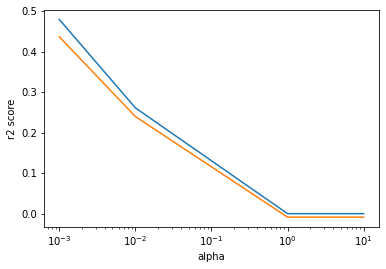

In [1625]:

# grid search CV

# set up cross validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# specify range of hyperparameters
params = {'alpha': [0.001, 0.01, 1.0, 5.0, 10.0]}


# Xtrain and Xtest without important 5 variables
X_train_m=X_train.drop(columns=dro_cols[1:])
X_test_m=X_test.drop(columns=dro_cols[1:])


# grid search
# lasso model
model = Lasso()
model_cv = GridSearchCV(estimator = model, param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True, verbose = 1)            
model_cv.fit(X_train_m, y_train) 

cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

# plot
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2 score')
plt.xscale('log')
plt.show()

In [1626]:
# lasso regression
lm = Lasso(alpha=0.001)
lm.fit(X_train_m, y_train)

# predict
print('Train score')
y_train_pred = lm.predict(X_train_m)
print(round(r2_score(y_true=y_train, y_pred=y_train_pred)*100,2))
y_test_pred = lm.predict(X_test_m)
print('Test score')
print(round(r2_score(y_true=y_test, y_pred=y_test_pred)*100,2))

model_parameters = list(lm.coef_)
model_parameters.insert(0, lm.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X_train_m.columns
cols = cols.insert(0, "constant")
coefs=sorted(list(zip(cols, model_parameters)),key=lambda x:abs(x[1]),reverse=True)
coefs[:6]

Train score
47.52
Test score
47.09


[('constant', 11.301),
 ('LotArea', 1.113),
 ('TtlPorchArea', 0.575),
 ('Neighborhood_NridgHt', 0.524),
 ('MSZoning_FV', 0.475),
 ('Neighborhood_StoneBr', 0.455)]